In [ ]:
print('s')

: 

In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series
import os
import warnings
import gc
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
%matplotlib inline


uses semicolons (;) as the delimiter instead of the more typical commas. The training dataset consists of two columns: Date and Egg Sales. The test dataset contains only the Date column, for which we'll need to predict Egg Sales.

In [2]:
# Reload the training and test datasets with the correct delimiter
train_df = pd.read_csv('/kaggle/input/egg-sales-predict-challenge-23sl/train_egg_sales.csv', delimiter=';')
test_df = pd.read_csv('/kaggle/input/egg-sales-predict-challenge-23sl/test_egg_sales.csv', delimiter=';')

# Display the first few rows of the training and test datasets
train_df.head()


,Date,Egg Sales
0,1993-01-01,91
1,1993-01-02,124
2,1993-01-03,112
3,1993-01-04,115
4,1993-01-05,107


In [3]:
 test_df.head()

,Date
0,2022-01-01
1,2022-01-02
2,2022-01-03
3,2022-01-04
4,2022-01-05


In [4]:
# Check for missing values and data types in the training dataset
train_info = train_df.info()
train_missing = train_df.isna().sum()

# Check for missing values and data types in the test dataset
test_info = test_df.info()
test_missing = test_df.isna().sum()

# Convert the 'Date' column to datetime format in both training and test datasets
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

train_info, train_missing, test_info, test_missing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10592 entries, 0 to 10591
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       10592 non-null  object
 1   Egg Sales  10592 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 165.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    358 non-null    object
dtypes: object(1)
memory usage: 2.9+ KB


(None,
 Date         0
 Egg Sales    0
 dtype: int64,
 None,
 Date    0
 dtype: int64)

## Good news
- The data doesn't have any missing values, which is good. We've also successfully converted the Date columns in both datasets to datetime format.

###  Feature Engineering

In [5]:
# Extract year, month, and day from the Date column in the training dataset
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Day'] = train_df['Date'].dt.day

# Extract year, month, and day from the Date column in the test dataset
test_df['Year'] = test_df['Date'].dt.year
test_df['Month'] = test_df['Date'].dt.month
test_df['Day'] = test_df['Date'].dt.day

# Display the first few rows of the modified training and test datasets
train_df.head(), test_df.head()


(        Date  Egg Sales  Year  Month  Day
 0 1993-01-01         91  1993      1    1
 1 1993-01-02        124  1993      1    2
 2 1993-01-03        112  1993      1    3
 3 1993-01-04        115  1993      1    4
 4 1993-01-05        107  1993      1    5,
         Date  Year  Month  Day
 0 2022-01-01  2022      1    1
 1 2022-01-02  2022      1    2
 2 2022-01-03  2022      1    3
 3 2022-01-04  2022      1    4
 4 2022-01-05  2022      1    5)

### Data Visualization
- do some visual for good understanding

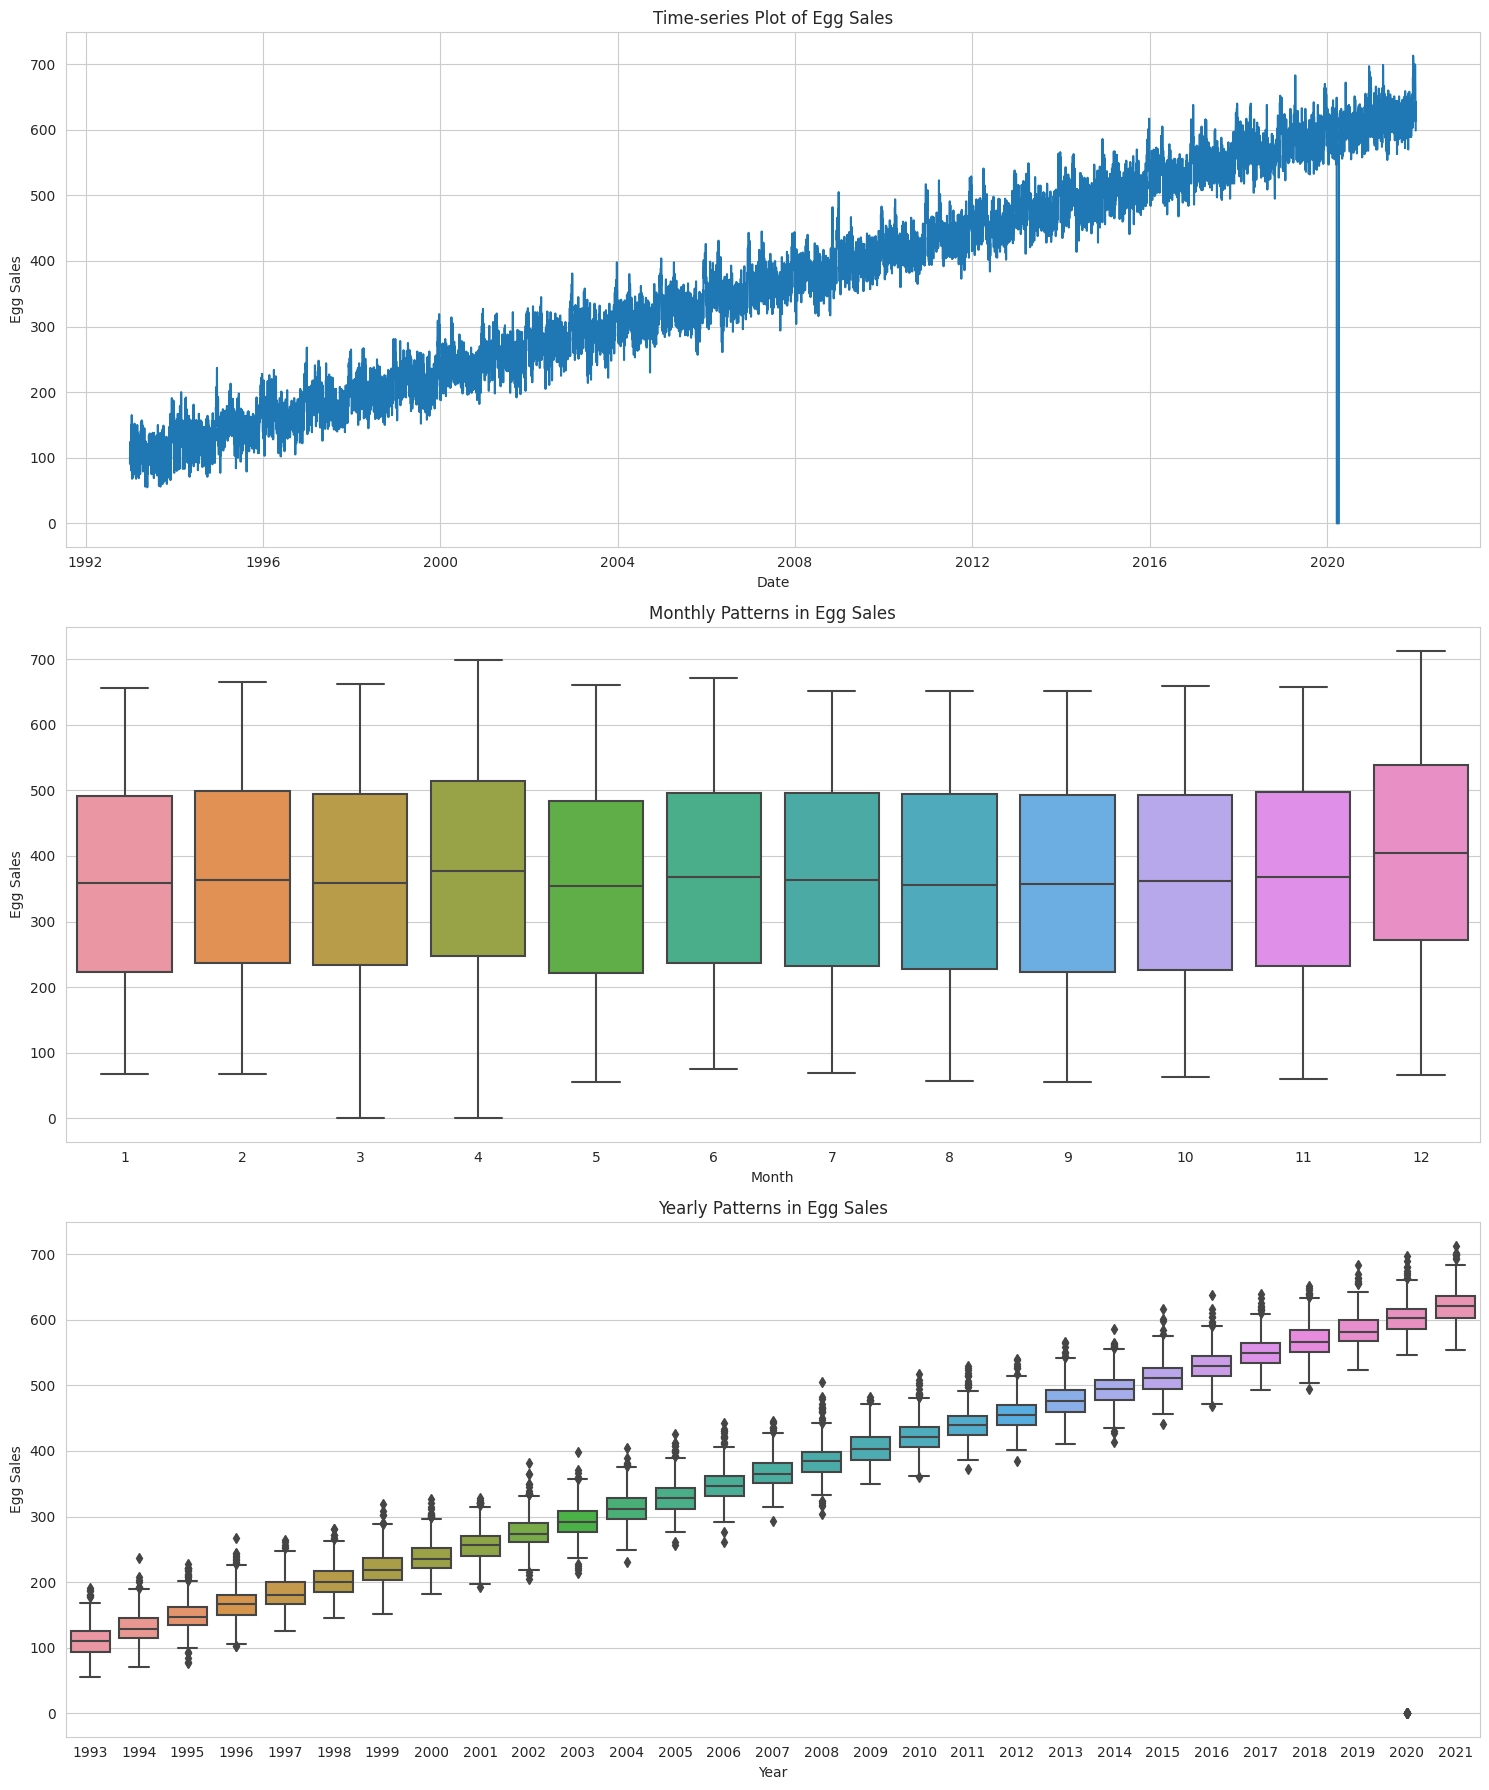

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Time-series plot of Egg Sales over time
sns.lineplot(x='Date', y='Egg Sales', data=train_df, ax=axes[0])
axes[0].set_title('Time-series Plot of Egg Sales')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Egg Sales')

# Monthly patterns in Egg Sales
sns.boxplot(x='Month', y='Egg Sales', data=train_df, ax=axes[1])
axes[1].set_title('Monthly Patterns in Egg Sales')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Egg Sales')

# Yearly patterns in Egg Sales
sns.boxplot(x='Year', y='Egg Sales', data=train_df, ax=axes[2])
axes[2].set_title('Yearly Patterns in Egg Sales')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Egg Sales')

plt.tight_layout()
plt.show()


- Time-series Plot of Egg Sales: This plot shows the overall trend and seasonality of egg sales over time. It seems there are some patterns, although the data is somewhat noisy.

- Monthly Patterns in Egg Sales: This boxplot shows the distribution of egg sales for each month. Some months appear to have higher median sales than others, suggesting seasonality.

- Yearly Patterns in Egg Sales: This boxplot shows the distribution of egg sales for each year. There seems to be an overall upward trend in sales over the years.

### Prepare data Training TEst

In [7]:
from sklearn.model_selection import train_test_split

# Drop the 'Date' column from the training dataset
train_df_dropped = train_df.drop(['Date'], axis=1)

# Separate features (X) and target variable (y)
X = train_df_dropped.drop(['Egg Sales'], axis=1)
y = train_df_dropped['Egg Sales']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the training and validation sets
X_train.shape, X_val.shape, y_train.shape, y_val.shape


((8473, 3), (2119, 3), (8473,), (2119,))

### Model Selection
For this task, we'll try different models to predict egg sales. Specifically, we'll experiment with:

- Linear Regression


## for this we used a SIMPLEST Linear Regression model

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initialize the models
linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

# Dictionary to store the performance metrics for each model
model_metrics = {}

# Train and evaluate Linear Regression model
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_val)
rmse_linear = np.sqrt(mean_squared_error(y_val, y_pred_linear))
mae_linear = mean_absolute_error(y_val, y_pred_linear)
model_metrics['Linear Regression'] = {'RMSE': rmse_linear, 'MAE': mae_linear}

model_metrics


{'Linear Regression': {'RMSE': 36.141750578603414, 'MAE': 20.902027016185578}}

In [9]:
# Drop the 'Date' column from the test dataset and prepare it for predictions
test_df_dropped = test_df.drop(['Date'], axis=1)

# Make predictions using the trained Linear Regression model
test_predictions_linear = linear_model.predict(test_df_dropped)

# Create a DataFrame to store the test predictions
test_output_linear = pd.DataFrame({
    'Date': test_df['Date'],
    'Predicted Egg Sales': test_predictions_linear
})

# Display the first few rows of the predicted test output
test_output_linear.head()

,Date,Predicted Egg Sales
0,2022-01-01,629.678703
1,2022-01-02,629.645568
2,2022-01-03,629.612434
3,2022-01-04,629.579299
4,2022-01-05,629.546165


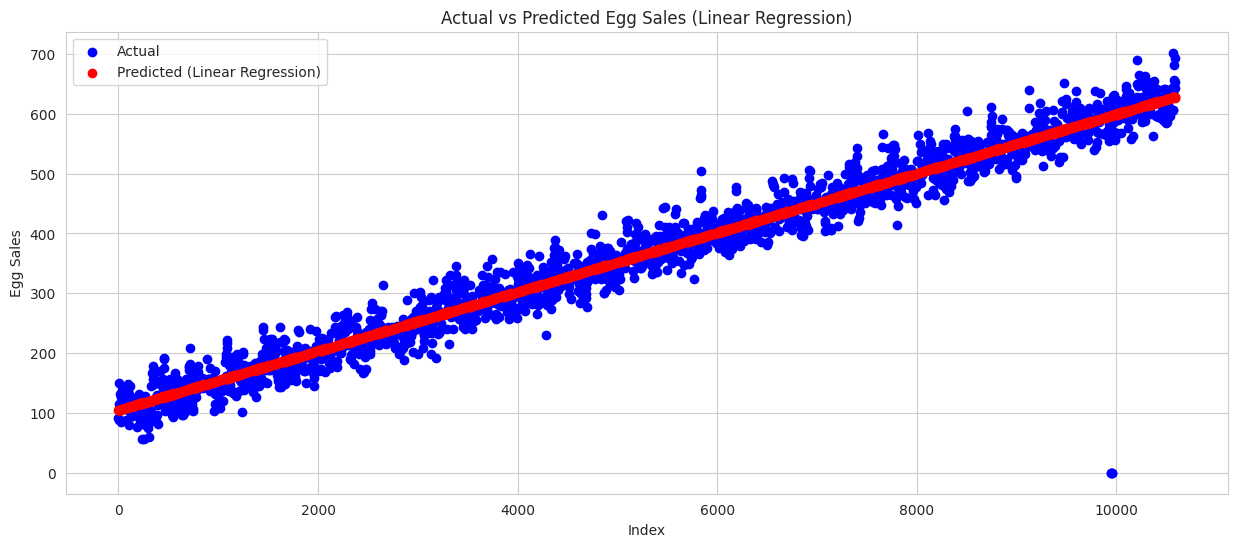

In [10]:
# Plotting the actual vs predicted values for the Linear Regression model
plt.figure(figsize=(15, 6))
plt.scatter(y_val.index, y_val, color='blue', label='Actual')
plt.scatter(y_val.index, y_pred_linear, color='red', label='Predicted (Linear Regression)')
plt.title('Actual vs Predicted Egg Sales (Linear Regression)')
plt.xlabel('Index')
plt.ylabel('Egg Sales')
plt.legend()
plt.show()

In [11]:
test_output_linear.columns = pd.read_csv('/kaggle/input/egg-sales-predict-challenge-23sl/sample_submission updated.csv', delimiter=';').columns

### Save the submission

In [12]:
test_output_linear.to_csv('submission.csv', index=False)

In [13]:
pd.read_csv('/kaggle/input/egg-sales-predict-challenge-23sl/sample_submission updated.csv', delimiter=';').columns

Index(['ID', 'Expected'], dtype='object')

In [14]:
pd.read_csv('submission.csv')

,ID,Expected
0,2022-01-01,629.678703
1,2022-01-02,629.645568
2,2022-01-03,629.612434
3,2022-01-04,629.579299
4,2022-01-05,629.546165
...,...,...
353,2022-12-20,645.444159
354,2022-12-21,645.411025
355,2022-12-22,645.377890
356,2022-12-23,645.344756
